**Outline**

The purpose of this script is to plot Bayes factors (BFs) for beta power at each time point vs baseline. 

**Import packages**

In [12]:

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


**Load computed BFs**

In [37]:
# Define path to data
data_path = os.path.join("/media/NAS/lbailey/PMBR_timecourse/output/1BP15")

# Read in the csv's containing Bayes factors over time. One contains BFs computed with default priors
# and the other contains BFs computed using a nullinterval
bfs_default = pd.read_csv(os.path.join(data_path, 
                               "BFs_on_beta_timecourse.csv"))

bfs_nullInterval = pd.read_csv(os.path.join(data_path, 
                               "BFs_on_beta_timecourse_nullInterval1000iters.csv"))

# Combine the two dataframes into one
bfs = pd.DataFrame()
bfs['Time'] = bfs_default['Time']
bfs['BF_MEG0211_def'] = bfs_default['BF_MEG0211_']
bfs['BF_MEG1311_def'] = bfs_default['BF_MEG1311_']


# the nullInterval column names contain prior widths, so use df.filter to select columns based on partial string match
bfs['BF_MEG0211_NI'] = bfs_nullInterval.filter(like='BF_MEG0211_') 
bfs['BF_MEG1311_NI'] = bfs_nullInterval.filter(like='BF_MEG1311_')

# Remove time points beyond 10s
bfs = bfs[bfs['Time'] <= 10]

**Define some parmeters for plotting**

In [38]:
# Use matplotlib's default colours for each channel, to maintain consistency with other plots
colours = ['#1f77b4', '#ff7f0e'] 

# Define the columns of bfs we want to plot
channels = ['MEG0211_def', 'MEG1311_def', 'MEG0211_NI', 'MEG1311_NI']

# Define titles for rows and columns
row_titles = ['Default\nJZS prior', 'Informed prior\n(with null interval)']
col_titles = ['Left (Contralateral)', 'Right (Ipsilateral)']

# Define ylims for the inset plots
inset_ylims = [1e-5, 1e3]

**Plot BFs over time**

We'll create a figure with columns for each channel and rows for computation type (default or nullInterval prior)

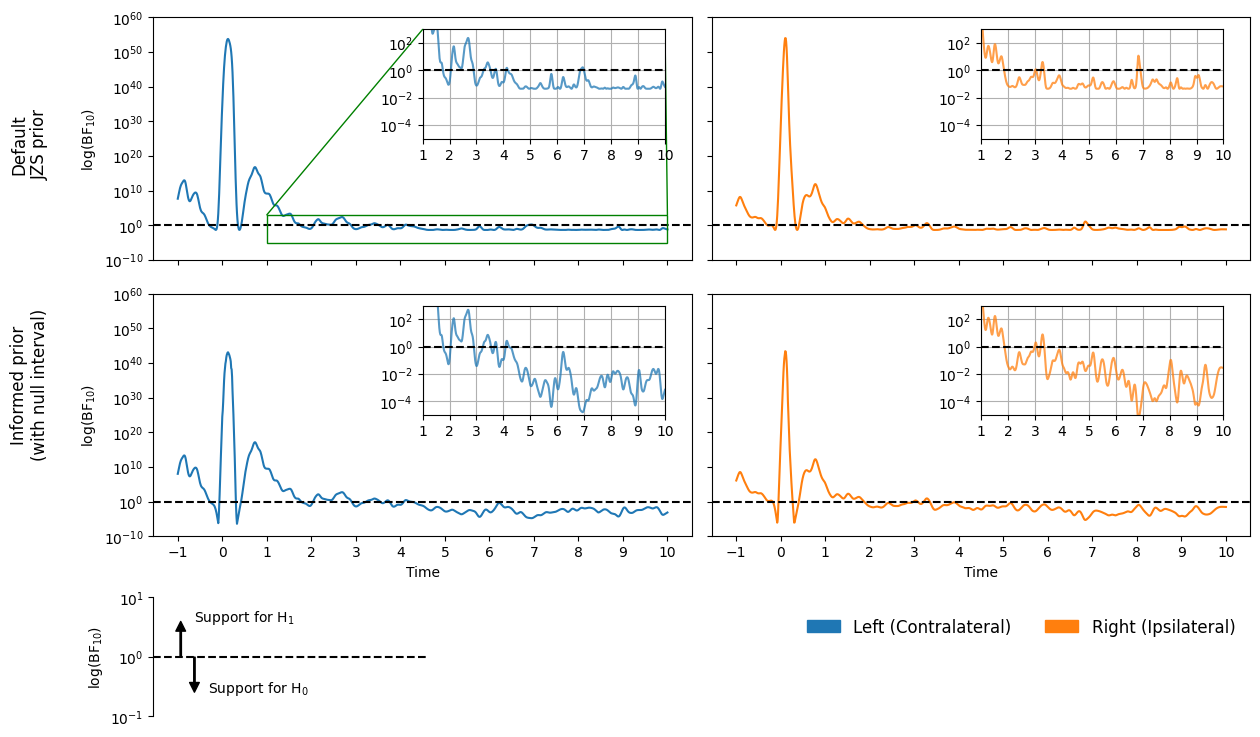

In [40]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6), sharey=True, sharex=True)
axs = axs.ravel()  # Flatten the array of axes

# Loop through subplots
for i, ax in enumerate(axs):
    
    # Determine the channel and color for this subplot
    channel = channels[i % len(channels)]
    color = colours[i % len(colours)]

    # Get data for this channel
    data = bfs[[f'BF_{channel}', 'Time']]

    ##########################################################################################
    # Main plot (showing full range of BFs over time)
    ##########################################################################################

    # Plot the BFs over time
    sns.lineplot(x='Time', y=f'BF_{channel}', data=data, ax=ax, color=color, label=None)

    # Add a horizontal line at BF = 1
    ax.axhline(y=1, color='k', linestyle='--')

    # Use log scale for y-axis and set an appropriate label
    ax.set_yscale('log')
    ax.set_ylabel('log(BF$_{10}$)')

    # Set y axis ticks
    ax.set_yticks([1e-10, 1e-0, 1e10, 1e20, 1e30, 1e40, 1e50, 1e60])

    # Set x axis ticks
    ax.set_xticks(np.linspace(-1, 10, 12).astype(int))

    ##########################################################################################
    # Inset plot (showing only low BFs)
    ##########################################################################################

    # Add an inset axis to the main plot
    axin1 = ax.inset_axes([0.5, 0.5, 0.45, 0.45])
    ax2 = sns.lineplot(x="Time", y=f'BF_{channel}', data=data, ax=axin1, alpha=0.75, errorbar=None, color = color)

    # Add a horizontal line to the inset axis at BF = 1
    ax2.axhline(y=1, color='k', linestyle='--', label = 'BF = 1')

    # Set scale parameters
    ax2.set_yscale('log')
    ax2.set_xlim(1, 10)
    ax2.set_xticks(np.linspace(1, 10, 10).astype(int))
    ax2.set_yticks([1e-4, 1e-2, 1e-0, 1e2])
    ax2.set_ylim(inset_ylims[0], inset_ylims[1]) 
    ax2.get_xaxis().get_major_formatter().labelOnlyBase = True
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)

    # Indicate the inset axes in the main plot, but only for the first subplot
    if i ==0:
        ax.indicate_inset([1, inset_ylims[0], 9, inset_ylims[1]], inset_ax=ax2, edgecolor='g', alpha = 1)
    
    # Add gridlines
    ax2.grid(axis='y')
    ax2.grid(axis='x')

##########################################################################################
# General formatting
##########################################################################################

# Add row titles
for i, row_title in enumerate(row_titles):
    fig.text(-0.03, 0.75 - i * 0.4, row_title, va='center', ha='center', rotation='vertical', fontsize=12)

# Adjust subplot layout
plt.tight_layout()
    
##########################################################################################
# Create a fifth axis (subplot) to act as a legend
##########################################################################################

# Add a fifth subplot
ax5 = fig.add_subplot(3, 1, 3)

# Add a line at BF = 1
ax5.axhline(1, color='k', linestyle='--')

# Add vertical arrows for H0 and H1...
# Add the arrow and text for > 1
ax5.annotate('',xy=(1, 4), xytext=(1, 1),   # xy = arrow end point, xytext = arrow start point
                arrowprops=dict(facecolor='black',width=1.0,headwidth=7.0,headlength=7.0,shrink=0.01),horizontalalignment='center')
ax5.annotate('Support for H$_{1}$', (1.5,4))

# Add the arrow and text for < 1
ax5.annotate('',xy=(1.5, 0.25), xytext=(1.5, 1),   # xy = arrow end point, xytext = arrow start point
                arrowprops=dict(facecolor='black',width=1.0,headwidth=7.0,headlength=7.0,shrink=0.01),horizontalalignment='center')
ax5.annotate('Support for H$_{0}$', (2,0.25))

# Set y scale parameters
ax5.set_ylim(0.1, 10)
ax5.set_yscale('log')
ax5.minorticks_off()
ax5.set_ylabel('log(BF$_{10}$)')

ax5.set_yticks([1e-1, 1e0, 1e1])

# Set x scale parameters
ax5.set_xlim(0, 10)
ax5.set_xticks([])

# Remove subplot frame on 3 edges
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)

##########################################################################################
# Create a legend for the whole figire
##########################################################################################

# It's easier to modify the legend for ax5 than for the main figure
pos = ax5.get_position()
ax5.set_position([pos.x0, pos.y0 - 0.3, pos.width*0.25, pos.height * 0.75])

# Define legend labels and handles
labels = ['Left (Contralateral)', 'Right (Ipsilateral)']
contra_patch = mpatches.Patch(color=colours[0], label='Contralateral')
ipsi_patch = mpatches.Patch(color=colours[1], label='Ipsilateral')
handles = [contra_patch, ipsi_patch]

ax5.legend(handles, labels, bbox_to_anchor=(4, 0.75), loc='right', ncols=2, frameon=False, prop={'size': 12})


